
# The grid

In [1]:
import matplotlib.pyplot as plt
import numpy as np

X_MIN = 0.0
X_MAX = 10.0
Y_MIN = 0.0
Y_MAX = 10.0
STEP = 0.1
THO = 1
W_MIN = -0.05
W_MAX = 0.05

x_axis = np.arange(X_MIN, X_MAX + STEP, STEP)
x_cells = np.column_stack((x_axis[:-1], x_axis[1:]))

cells = np.array([
    [
        [x_cells[i], x_cells[j]]
        for i in range(len(x_cells))
    ]
    for j in range(len(x_cells))
])

state_intervals = {
    (i, j): cells[j, i]
    for i in range(len(cells))
    for j in range(len(cells))
}

def locate(x,y):
    if (x<0 or x>=10 or y<0 or y>=10): return (-1,-1)
    temp1 = int(x*10)
    temp2 = int(y*10)
    return (temp1, temp2)

# Transition function

In [2]:
inputs = [(i,j) for i in [-0.25, 0.625, 1] for j in [-1, 0, 1]]


def f(x,y,u1,u2,w1,w2):

  Xsucc = x + THO * (u1 + w1)
  Ysucc = y + THO * (u2 + w2)

  return Xsucc, Ysucc

def goTo(i,j, u1, u2):
    xmin = state_intervals[i,j][0,0]
    xmax = state_intervals[i,j][0,1]
    ymin = state_intervals[i,j][1,0]
    ymax = state_intervals[i,j][1,1]

    resXMin, resYMin = f(xmin, ymin, u1, u2, W_MIN, W_MIN)
    resXMax, resYMax = f(xmax, ymax, u1, u2, W_MAX, W_MAX)


    if (resXMin>=10 or resXMax<0) or (resYMin>=10 or resYMax<0):
        return []

    if resXMin < 0: resXMin = 0
    if resXMax >= 10: resXMax = 9.995
    if resYMin < 0: resYMin = 0
    if resYMax >= 10: resYMax = 9.995

    successeur = []
    bornes = [locate(x,y) for x in [resXMin, resXMax] for y in [resYMin, resYMax]]
    for i in range(bornes[0][0], bornes[2][0]+1):
        for j in range(bornes[0][1], bornes[3][1]+1):
            if i<0 or i>=100 or j<0 or j>=100:
                continue
            successeur.append((i,j))
    return successeur


# Specification de surete

In [3]:
def area(Xmin,Xmax,Ymin,Ymax):
  target = []
  bornes = [locate(x,y) for x in [Xmin, Xmax] for y in [Ymin, Ymax]]
  for i in range(bornes[0][0], bornes[2][0]+1):
      for j in range(bornes[0][1], bornes[3][1]+1):
          if i<0 or i>=100 or j<0 or j>=100:
              continue
          target.append((i,j))
  return target


In [4]:
avoid_area = area(3,4,3,4)
avoid_area1 = area(3,4,3,4)
avoid_area2 = area(8,9,7.5,9)
avoid_area3 = area(2,3,8,9)
safe_area = [x for x in state_intervals.keys() if x not in avoid_area]

In [5]:
def Pre(R):
    R1 = set(R)
    predecesseur = []
    for etat in state_intervals.keys():
        for input in inputs:
            temp = goTo(etat[0], etat[1], input[0], input[1])
            flag = 1 if len(temp)!=0 else 0
            for state in temp:
                if state not in R1:
                    flag = 0
                    break
            if flag:
                predecesseur.append(etat)
                break
    return predecesseur

def pointFixe(Q):
    Q1 = set(Q)
    R0 = Q
    prede = Pre(R0)
    R1 = [x for x in prede if x in Q1]
    while R1!=R0:
        R0 = R1
        prede = Pre(R0)
        R1 = [x for x in prede if x in Q1]
    return R1


R_star = pointFixe(safe_area)



# Controlleur symbolique


In [6]:
import random
controlleur_surete = {}
for etat in R_star:
  controlleur_surete[etat] = []
  for input in inputs:
    temp = goTo(etat[0], etat[1], input[0], input[1])
    if temp and all([x in R_star for x in temp]):
      controlleur_surete[etat].append(input)

In [7]:
def move(startState, epoches):
  setOfStates = [startState]
  for i in range(epoches):
    chosenInput = random.choice(controlleur_surete[startState])
    nextState = random.choice(goTo(startState[0], startState[1], chosenInput[0], chosenInput[1]))
    setOfStates.append(nextState)
    startState = nextState
  return setOfStates


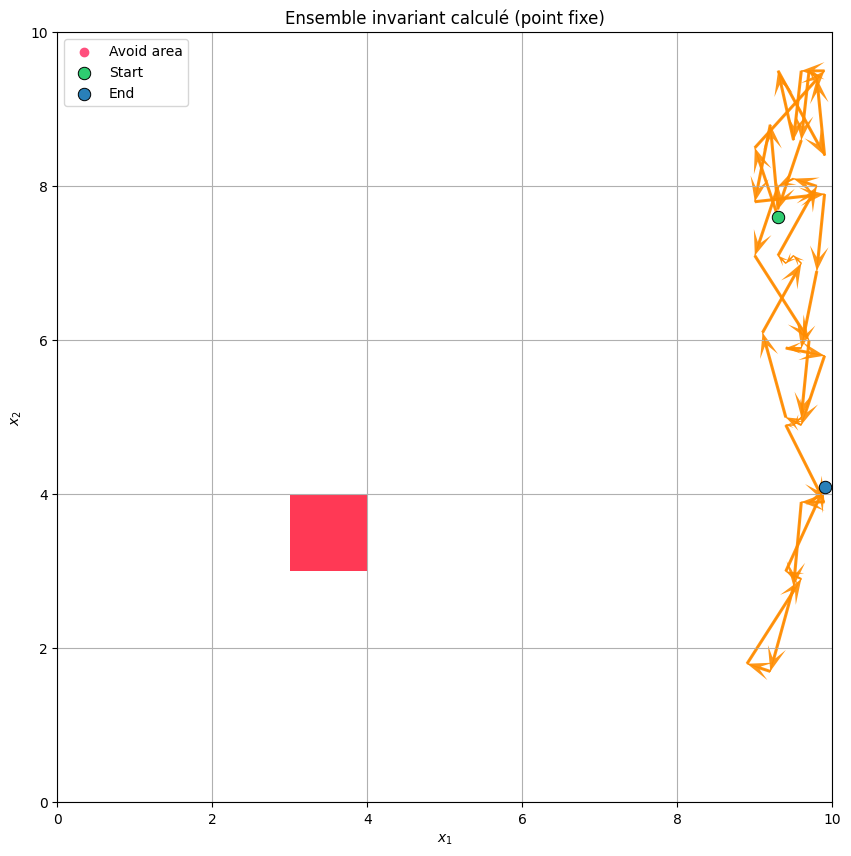

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import random

start = random.choice(list(controlleur_surete.keys()))
trajectoire = move(start, 40)

fig, ax = plt.subplots(figsize=(10, 10))

def plot_area(ax, avoid_area):
    if len(avoid_area) > 0:
        res_arr = np.array(avoid_area)
        x = res_arr[:, 0] / 10
        y = res_arr[:, 1] / 10

        # Zone remplie, couleur forte
        ax.tricontourf(
            x, y, np.zeros_like(x),
            levels=1,
            colors=['#ff4f7d'],
            alpha=0.95
        )

        # Halo plus dramatique
        ax.tricontourf(
            x, y, np.zeros_like(x),
            levels=1,
            colors=['red'],
            alpha=0.35
        )

        # Contour rouge TRES visible
        ax.tricontour(
            x, y, np.zeros_like(x),
            levels=1,
            colors='red',
            linewidths=3.5
        )


# Dummy scatter for legend
ax.scatter([], [], color='#ff4f7d', label='Avoid area')

# Plot all avoid areas first
plot_area(ax, avoid_area1)

# Then plot trajectory
if len(trajectoire) > 0:
    traj_x = [s[0] / 10 for s in trajectoire]
    traj_y = [s[1] / 10 for s in trajectoire]

    # Thin but visible line
    ax.plot(traj_x, traj_y, color='darkorange', linewidth=0.8, alpha=0.9)

    # Direction arrows with thick heads
    ax.quiver(
        traj_x[:-1], traj_y[:-1],
        np.diff(traj_x), np.diff(traj_y),
        angles='xy', scale_units='xy', scale=1,
        width=0.004,
        headwidth=6,
        headlength=8,
        color='darkorange',
        alpha=0.9
    )

    # Start point
    ax.scatter(traj_x[0], traj_y[0], color='#2ecc71', s=80,
               edgecolor='black', linewidth=0.7, zorder=5, label='Start')

    # End point
    ax.scatter(traj_x[-1], traj_y[-1], color='#2980b9', s=80,
               edgecolor='black', linewidth=0.7, zorder=5, label='End')

    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title('Ensemble invariant calculé (point fixe)')
    ax.legend()
    ax.grid(True)
    plt.show()
else:
    print("⚠️ 'trajectoire' is empty — nothing to plot.")


# specification d'atteignabilité

In [9]:
def pointFixeAtteignabilité(Q):
    controlleur_atteint = {}
    R0 = Q
    prede = Pre(R0)
    R1 = set(prede+R0)
    for etat in R1:
      if etat not in Q:
        controlleur_atteint[etat] = []
        for input in inputs:
          successeurs = goTo(etat[0], etat[1], input[0], input[1])
          if successeurs and all([x in R0 for x in successeurs]):
            controlleur_atteint[etat].append(input)
    while R1!=R0:
        R0 = R1
        prede = Pre(R0)
        R1 = set(Q+prede)
        for etat in R1:
          if etat not in Q and etat not in controlleur_atteint.keys():
            controlleur_atteint[etat] = []
            for input in inputs:
              successeurs = goTo(etat[0], etat[1], input[0], input[1])
              if successeurs and all([x in R0 for x in successeurs]):
                controlleur_atteint[etat].append(input)
    return controlleur_atteint

In [10]:
target = area(8,9,8,9)
controlleur_atteint = pointFixeAtteignabilité(target)

In [ ]:
trajectoire = []
depart = random.choice(list(controlleur_atteint.keys()))
trajectoire.append(depart)
flag = True
while flag:
  input = random.choice(controlleur_atteint[depart])
  etat = random.choice(goTo(depart[0], depart[1], input[0], input[1]))
  trajectoire.append(etat)
  depart = etat
  if depart in target:
    flag = False

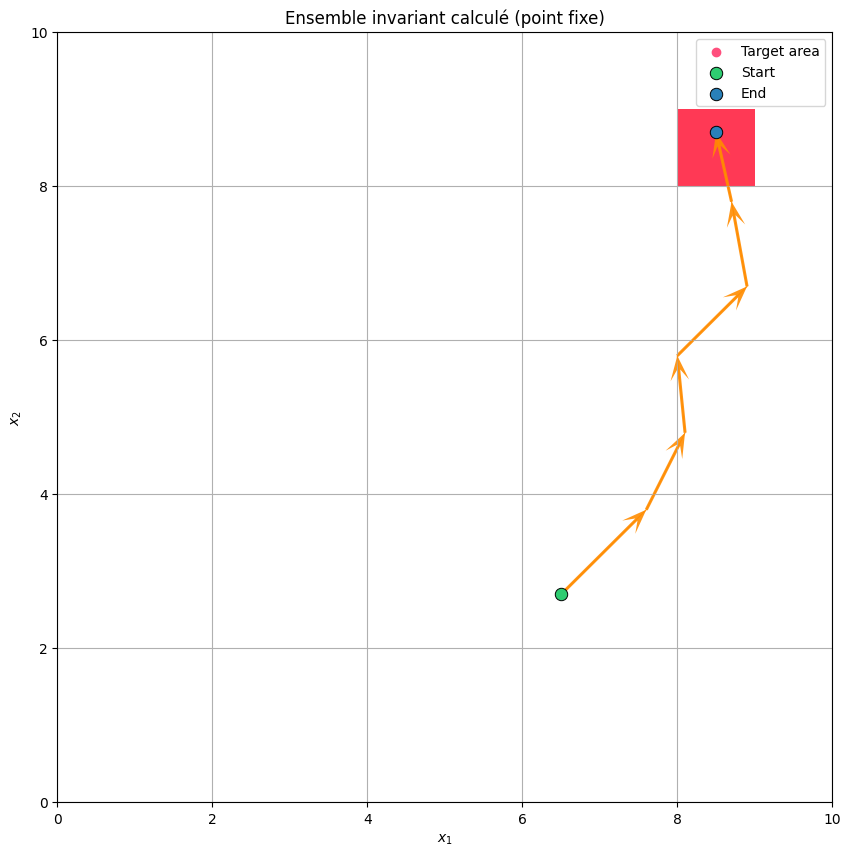

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

start = depart


fig, ax = plt.subplots(figsize=(10, 10))

def plot_area(ax, avoid_area):
    if len(avoid_area) > 0:
        res_arr = np.array(avoid_area)
        x = res_arr[:, 0] / 10
        y = res_arr[:, 1] / 10

        # Zone remplie, couleur forte
        ax.tricontourf(
            x, y, np.zeros_like(x),
            levels=1,
            colors=['#ff4f7d'],
            alpha=0.95
        )

        # Halo plus dramatique
        ax.tricontourf(
            x, y, np.zeros_like(x),
            levels=1,
            colors=['red'],
            alpha=0.35
        )

        # Contour rouge TRES visible
        ax.tricontour(
            x, y, np.zeros_like(x),
            levels=1,
            colors='red',
            linewidths=3.5
        )


# Dummy scatter for legend
ax.scatter([], [], color='#ff4f7d', label='Target area')

# Plot all avoid areas first
plot_area(ax, target)

# Then plot trajectory
if len(trajectoire) > 0:
    traj_x = [s[0] / 10 for s in trajectoire]
    traj_y = [s[1] / 10 for s in trajectoire]

    # Thin but visible line
    ax.plot(traj_x, traj_y, color='darkorange', linewidth=0.8, alpha=0.9)

    # Direction arrows with thick heads
    ax.quiver(
        traj_x[:-1], traj_y[:-1],
        np.diff(traj_x), np.diff(traj_y),
        angles='xy', scale_units='xy', scale=1,
        width=0.004,
        headwidth=6,
        headlength=8,
        color='darkorange',
        alpha=0.9
    )

    # Start point
    ax.scatter(traj_x[0], traj_y[0], color='#2ecc71', s=80,
               edgecolor='black', linewidth=0.7, zorder=5, label='Start')

    # End point
    ax.scatter(traj_x[-1], traj_y[-1], color='#2980b9', s=80,
               edgecolor='black', linewidth=0.7, zorder=5, label='End')

    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title('Ensemble invariant calculé (point fixe)')
    ax.legend()
    ax.grid(True)
    plt.show()
else:
    print("⚠️ 'trajectoire' is empty — nothing to plot.")


# intersection des deux spécifications

In [ ]:
controlleur_Suerete_states = {}
for x in controlleur_surete:
  controlleur_Suerete_states[x] = set()
  for input in controlleur_surete[x]:
    temp = goTo(x[0], x[1], input[0], input[1])
    for y in temp:
      controlleur_Suerete_states[x].add(y)
  controlleur_Suerete_states[x] = list(controlleur_Suerete_states[x])

controlleur_Atteint_states = {}
for x in controlleur_atteint:
  controlleur_Atteint_states[x] = set()
  for input in controlleur_atteint[x]:
    temp = goTo(x[0], x[1], input[0], input[1])
    for y in temp:
      controlleur_Atteint_states[x].add(y)
  controlleur_Atteint_states[x] = list(controlleur_Atteint_states[x])


In [ ]:
controlleur_intersection = {}

for x in controlleur_Suerete_states:
    if x in controlleur_Atteint_states:
        common = [
            y
            for y in controlleur_Suerete_states[x]
            if y in controlleur_Atteint_states[x]
        ]
        controlleur_intersection[x] = common

while any([not controlleur_intersection[x] for x in controlleur_intersection]):
  for x in list(controlleur_intersection.keys()):
    if not controlleur_intersection[x]:
      trap = x
      del(controlleur_intersection[x])
      for y in controlleur_intersection:
        if trap in controlleur_intersection[y]:
          controlleur_intersection[y].remove(trap)


In [ ]:
trajectoire_inter = []
depart = random.choice(list(controlleur_intersection.keys()))
trajectoire_inter.append(depart)
flag = True
while flag:
  etat = random.choice(controlleur_intersection[depart])
  trajectoire_inter.append(etat)
  depart = etat
  if depart in target:
    flag = False

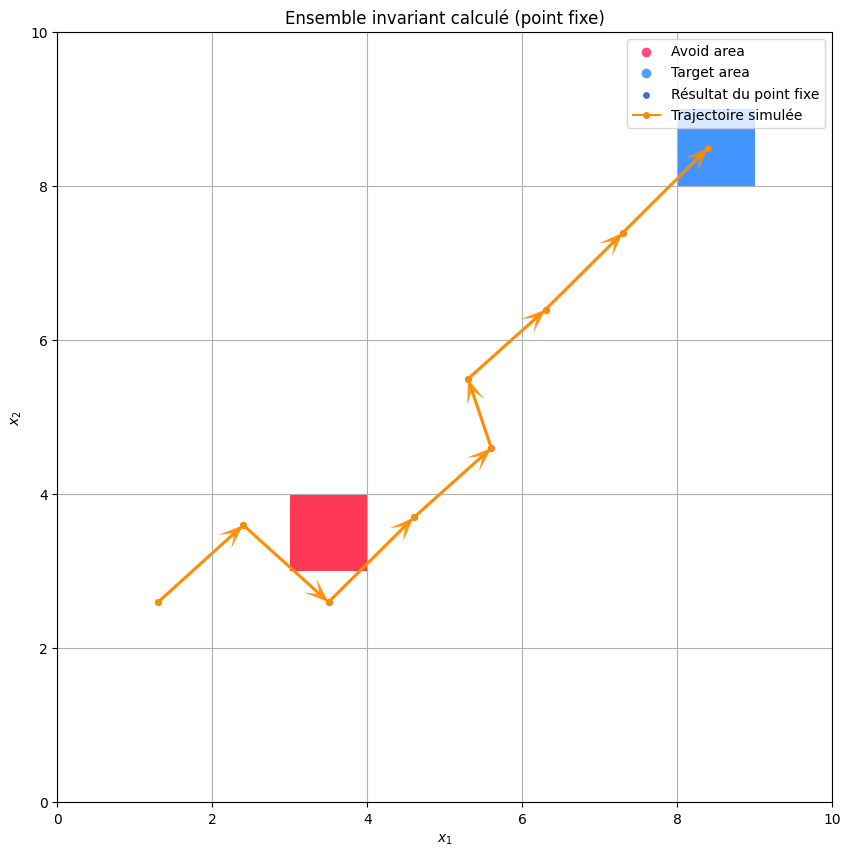

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 10))


# =========================================================
# Helper: plot a region with STYLE A (filled + halo + contour)
# =========================================================
def plot_strong_area(ax, area_states, color_fill, color_halo, color_contour, label):
    if len(area_states) == 0:
        return

    res_arr = np.array(area_states)
    x = res_arr[:, 0] / 10
    y = res_arr[:, 1] / 10

    # Strong filled zone
    ax.tricontourf(
        x, y, np.zeros_like(x),
        levels=1,
        colors=[color_fill],
        alpha=0.95
    )

    # Halo
    ax.tricontourf(
        x, y, np.zeros_like(x),
        levels=1,
        colors=[color_halo],
        alpha=0.35
    )

    # Thick contour
    ax.tricontour(
        x, y, np.zeros_like(x),
        levels=1,
        colors=color_contour,
        linewidths=3.5
    )

    # Dummy scatter for legend
    ax.scatter([], [], color=color_fill, label=label)



# =========================================================
# 1) Plot AVOID area (RED)
# =========================================================
plot_strong_area(
    ax,
    avoid_area,
    color_fill='#ff4f7d',     # deep pink fill
    color_halo='red',          # red halo
    color_contour='red',       # red contour
    label='Avoid area'
)


# =========================================================
# 2) Plot TARGET area (BLUE)
# =========================================================
plot_strong_area(
    ax,
    target,
    color_fill='#4fa3ff',      # strong blue fill
    color_halo='#1e6fff',      # blue halo
    color_contour='#1e6fff',   # blue contour
    label='Target area'
)


# =========================================================
# 3) Plot trajectoire_inter
# =========================================================
if len(trajectoire_inter) > 0:

    traj_x = [s[0] / 10 for s in trajectoire_inter]
    traj_y = [s[1] / 10 for s in trajectoire_inter]

    traj_arr = np.array(trajectoire_inter)

    # Blue points (path samples)
    ax.scatter(
        traj_arr[:, 0] / 10,
        traj_arr[:, 1] / 10,
        s=15,
        color='royalblue',
        label='Résultat du point fixe'
    )

    # Orange trajectory line
    ax.plot(
        traj_x, traj_y,
        '-o',
        color='darkorange',
        linewidth=1.5,
        markersize=4,
        label='Trajectoire simulée'
    )

    # Arrows
    if len(traj_x) > 1:
        ax.quiver(
            traj_x[:-1], traj_y[:-1],
            np.diff(traj_x), np.diff(traj_y),
            angles='xy', scale_units='xy', scale=1,
            width=0.004,
            headwidth=6,
            headlength=8,
            color='darkorange',
            alpha=0.9
        )


# =========================================================
# 4) Final styling
# =========================================================
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Ensemble invariant calculé (point fixe)')
ax.legend()
ax.grid(True)

plt.show()


# spécification basée sur les automates

#### fonctions et variables nécessaire au bon déroulet du code :

In [ ]:
automate = {
    "a":{0:"a",1:"b",2:"c",3:"a",4:"e"},
    "b":{0:"b",1:"b",2:"e",3:"d",4:"e"},
    "c":{0:"c",1:"e",2:"c",3:"d",4:"e"},
    "d":{0:"d",1:"d",2:"d",3:"d",4:"d"},
    "e":{0:"e",1:"e",2:"e",3:"e",4:"e"}
    }

In [ ]:
Q1 = area(4,5,8.5,9.5)
Q2 = area(8.5,9.5,2,3)
Q3 = area(2,3,0.5,1.5)
Q4 = area(3,7,3,7)

setQ1 = set(Q1); setQ2 = set(Q2); setQ3 = set(Q3); setQ4 = set(Q4)

In [ ]:
def labelisation(etat):
  if etat in setQ1: return 1
  if etat in setQ2: return 2
  if etat in setQ3: return 3
  if etat in setQ4: return 4
  return 0

def h1(state,etat):
  return automate[state][labelisation(etat)]

In [ ]:
space = [(state,etat) for state in ["a","b","c","d","e"] for etat in state_intervals.keys() ]

def g(state,etat,input):
  res = []
  for etat_successeur in goTo(etat[0],etat[1],input[0],input[1]):
    res.append((h1(state,etat_successeur),etat_successeur))
  return res

In [ ]:
controlleur_automate = {}
def predecessueur(R):
  predecesseurs = []
  Rset = set(R)
  for state,etat in space:
    if (state,etat) in controlleur_automate:
      continue
    taken = False
    for input in inputs:
      temp = g(state,etat,input)
      if not temp:
        continue
      if all([x in Rset for x in temp]):
        if not taken:
          predecesseurs.append((state,etat))
          controlleur_automate[(state,etat)] = [input]
          taken = True;
        else:
          controlleur_automate[(state,etat)].append(input)

  return predecesseurs

In [ ]:
def point_fixe_automate(Q):
  R0 = Q
  prede = predecessueur(R0)
  R1 = prede+R0
  while R1!=R0:
    R0 = R1
    prede = predecessueur(R0)
    R1 = R0+prede
  return R1

R_star_automate = point_fixe_automate([etat for etat in space if etat[0]=="d"])
def h2(state,etat):
  return controlleur_automate[(state,etat)]


In [ ]:
possible_starts = [x for x in controlleur_automate.keys() if x[0] == "a"]

#### blueprint du code


In [ ]:
etat = random.choice(possible_starts)
trajectoire_automate = [etat[1]]

while etat[0] != "d":
  input = random.choice(h2(etat[0], etat[1]))
  etat = random.choice(g(etat[0],etat[1],input))
  trajectoire_automate.append(etat[1])

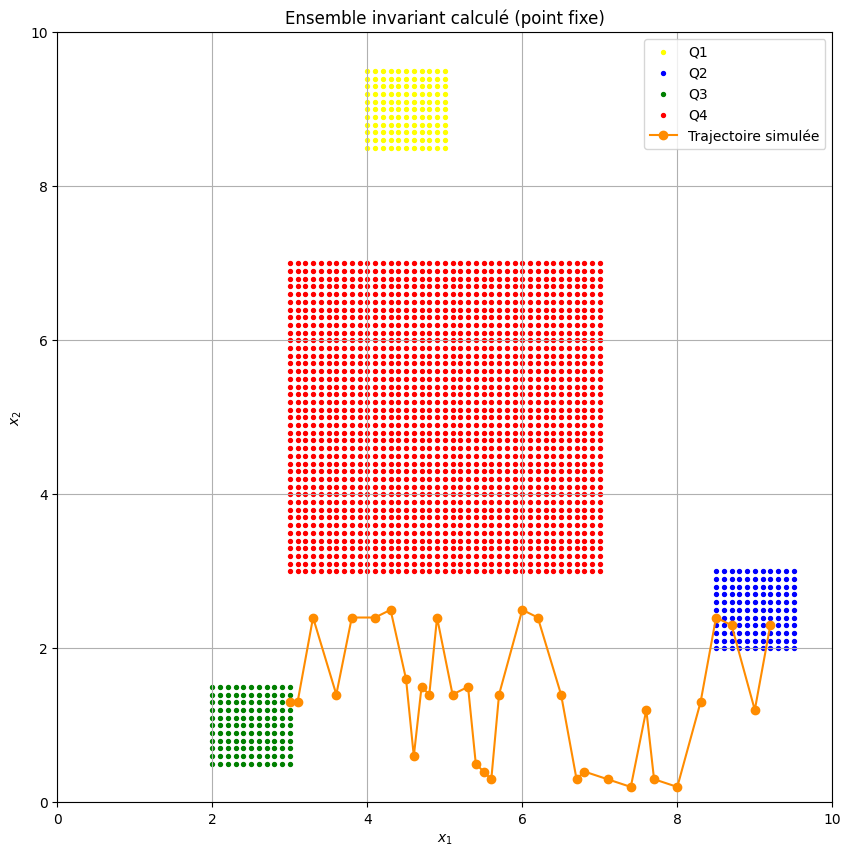

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 10))

if len(Q1) > 0:
    res_arr = np.array(Q1)
    ax.scatter(res_arr[:, 0] / 10, res_arr[:, 1] / 10, s=8, color='yellow', label='Q1')

if len(Q2) > 0:
    res_arr = np.array(Q2)
    ax.scatter(res_arr[:, 0] / 10, res_arr[:, 1] / 10, s=8, color='blue', label='Q2')

if len(Q3) > 0:
    res_arr = np.array(Q3)
    ax.scatter(res_arr[:, 0] / 10, res_arr[:, 1] / 10, s=8, color='green', label='Q3')

if len(Q4) > 0:
    res_arr = np.array(Q4)
    ax.scatter(res_arr[:, 0] / 10, res_arr[:, 1] / 10, s=8, color='red', label='Q4')




# If trajectoire is a list of points [(x1, y1), (x2, y2), ...]
if len(trajectoire_automate) > 0:
    traj_x = [s[0] / 10 for s in trajectoire_automate]
    traj_y = [s[1] / 10 for s in trajectoire_automate]



    # Convert to NumPy array for convenience
    traj_arr = np.array(trajectoire_automate)


    if len(traj_x) > 1:
        ax.plot(traj_x, traj_y, '-o', color='darkorange', label='Trajectoire simulée')

    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title('Ensemble invariant calculé (point fixe)')
    ax.legend()
    ax.grid(True)

    plt.show()
else:
    print("⚠️ 'trajectoire' is empty — nothing to plot.")

# Nouvelle spécification (basée sur les automates)

In [13]:
automate_mars = {
    "a": {0:"a", 1:"b", 2:"a", 3:"a", 4:"e", 5:"e"},
    "b": {0:"b", 1:"b", 2:"c", 3:"b", 4:"e", 5:"e"},
    "c": {0:"c", 1:"c", 2:"c", 3:"d", 4:"e", 5:"e"},
    "d": {0:"d", 1:"d", 2:"d", 3:"d", 4:"e", 5:"e"},
    "e": {0:"e", 1:"e", 2:"e", 3:"e", 4:"e", 5:"e"}
}

In [14]:
Q1 = area(4,5,8.5,9.5)
Q2 = area(8.5,9.5,2,3)
Q3 = area(2,3,0.5,1.5)
Q4 = area(3,5,3,5)
Q5 = area(6,7,5,7)

In [11]:
def labelisation(etat):
  if etat in Q1: return 1
  if etat in Q2: return 2
  if etat in Q3: return 3
  if etat in Q4: return 4
  if etat in Q5: return 5
  return 0

def h1(state,etat):
  return automate_mars[state][labelisation(etat)]

In [12]:
space = [(state,etat) for state in ["a","b","c","d","e"] for etat in state_intervals.keys()]

def g(state,etat,input):
  res = []
  for etat_successeur in goTo(etat[0],etat[1],input[0],input[1]):
    res.append((h1(state,etat_successeur),etat_successeur))
  return res

In [15]:
controlleur_automate = {}
def predecessueur(R):
  res = []
  Rset = set(R)
  for state,etat in space:
    if (state,etat) in controlleur_automate:
      continue
    taken = False
    for input in inputs:
      temp = g(state,etat,input)
      if not temp:
        continue
      if all([x in Rset for x in temp]):
        if not taken:
          res.append((state,etat))
          controlleur_automate[(state,etat)] = [input]
          taken = True;
        else:
          controlleur_automate[(state,etat)].append(input)

  return res

In [19]:
def point_fixe_automate(Q):
  R0 = Q
  prede = predecessueur(R0)
  R1 = prede+R0
  while R1!=R0:
    R0 = R1
    prede = predecessueur(R0)
    R1 = R0+prede
  return R1

Q0 = point_fixe_automate([etat for etat in space if etat[0]=="d"])
def h2(state,etat):
  return controlleur_automate[(state,etat)]


In [18]:
possible_starts = [x for x in controlleur_automate.keys() if x[0] == "a"]

In [20]:
etat = random.choice(possible_starts)
trajectoire_automate = [etat[1]]

while etat[0] != "d":
  input = random.choice(h2(etat[0], etat[1]))
  etat = random.choice(g(etat[0],etat[1],input))
  trajectoire_automate.append(etat[1])

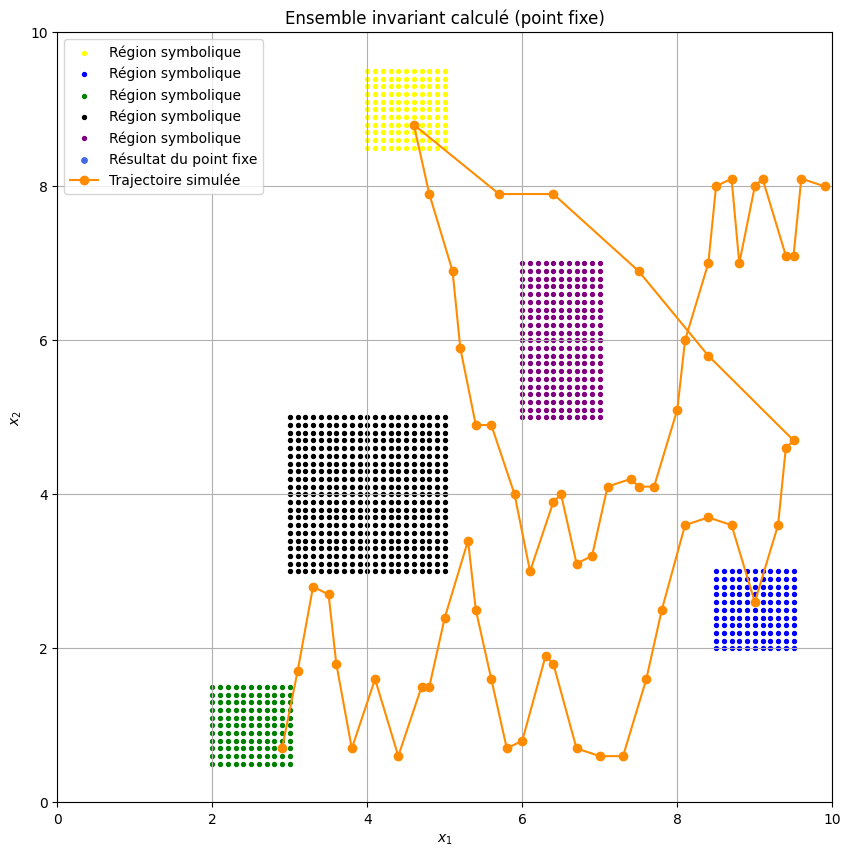

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 10))

if len(Q1) > 0:
    res_arr = np.array(list(Q1))
    ax.scatter(res_arr[:, 0] / 10, res_arr[:, 1] / 10, s=8, color='yellow', label='Région symbolique')

if len(Q2) > 0:
    res_arr = np.array(list(Q2))
    ax.scatter(res_arr[:, 0] / 10, res_arr[:, 1] / 10, s=8, color='blue', label='Région symbolique')

if len(Q3) > 0:
    res_arr = np.array(list(Q3))
    ax.scatter(res_arr[:, 0] / 10, res_arr[:, 1] / 10, s=8, color='green', label='Région symbolique')

if len(Q4) > 0:
    res_arr = np.array(list(Q4))
    ax.scatter(res_arr[:, 0] / 10, res_arr[:, 1] / 10, s=8, color='black', label='Région symbolique')

if len(Q5) > 0:
  res_arr = np.array(list(Q5))
  ax.scatter(res_arr[:, 0] / 10, res_arr[:, 1] / 10, s=8, color='purple', label='Région symbolique')

# if len(Q6) > 0:
#     res_arr = np.array(list(Q6))
#     ax.scatter(res_arr[:, 0] / 10, res_arr[:, 1] / 10, s=8, color='red', label='Région symbolique')

# if len(Q7) > 0:
#     res_arr = np.array(list(Q7))
#     ax.scatter(res_arr[:, 0] / 10, res_arr[:, 1] / 10, s=8, color='red', label='Région symbolique')


# If trajectoire is a list of points [(x1, y1), (x2, y2), ...]
if len(trajectoire_automate) > 0:
    traj_x = [s[0] / 10 for s in trajectoire_automate]
    traj_y = [s[1] / 10 for s in trajectoire_automate]



    # Convert to NumPy array for convenience
    traj_arr = np.array(trajectoire_automate)
    ax.scatter(traj_arr[:, 0] / 10, traj_arr[:, 1] / 10,
               s=15, color='royalblue', label='Résultat du point fixe')

    if len(traj_x) > 1:
        ax.plot(traj_x, traj_y, '-o', color='darkorange', label='Trajectoire simulée')

    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title('Ensemble invariant calculé (point fixe)')
    ax.legend()
    ax.grid(True)

    plt.show()
else:
    print("⚠️ 'trajectoire' is empty — nothing to plot.")